# Simulating 1/f-like noise and oscillatory signals with neurodsp.sim
In this notebook, we simulate 'brown'-like noise from several models, stationary and non-stationary oscillators, and the two together using the simulation library, `sim`, in `neurodsp`.

In [1]:
import numpy as np
np.random.seed(0)

from neurodsp import spectral, sim

%matplotlib inline
import matplotlib.pyplot as plt

# Simulate brown noise
Often, we want to simulate noise that is comparable to what we see in neural recordings. Brown noise is a good proxy for that because, like neural signals, power decreases roughly linearly with frequency. 

Text(0,0.5,'Power')

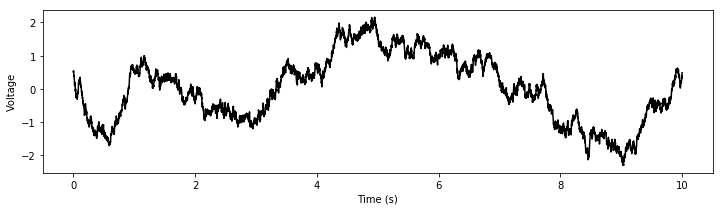

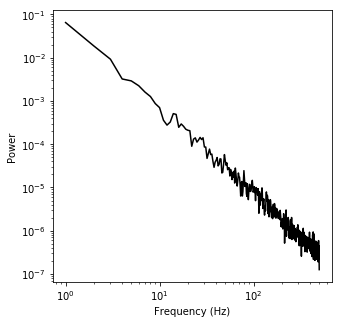

In [2]:
# Simulate brown noise
n_seconds = 10
fs = 1000
exponent = -2
t = np.arange(0, n_seconds, 1/fs)
br_noise = sim.sim_variable_powerlaw(n_seconds, fs, exponent)

# Plot time series
plt.figure(figsize=(12,3))
plt.plot(t, br_noise, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

# Plot power spectrum
freqs, psd = spectral.compute_spectrum(br_noise, fs)
plt.figure(figsize=(5,5))
plt.loglog(freqs, psd, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

# Simulate filtered brown noise
However, brown noise has a lot of power in very slow frequnecies, whereas these slow frequencies are often not present or filtered out in neural signals. Therefore, we may desire our brown noise to be high-pass filtered. See that the resulting signal has much less low-frequency drift.

Note this might not be ideal because it creates an "oscillation" at the cutoff frequency.

NOTE: Increased high-pass filter order by 1 in order to be odd


/Users/rdgao/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/rdgao/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/rdgao/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inter

Text(0,0.5,'Power')

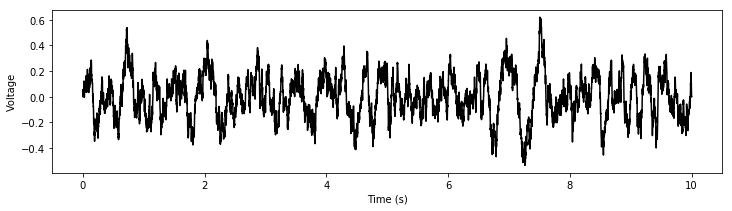

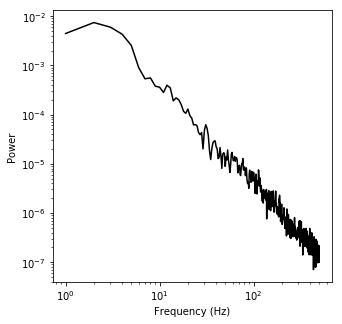

In [3]:
# Simulate highpass-filtered brown noise with a 1Hz cutoff frequency
f_hipass_brown = 1
brown_filt = sim.sim_filtered_noise(n_seconds, fs, exponent, (f_hipass_brown, None))

# Plot time series
plt.figure(figsize=(12,3))
plt.plot(t, brown_filt, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

# Plot power spectrum
f, psd = spectral.compute_spectrum(brown_filt, fs)
plt.figure(figsize=(5,5))
plt.loglog(f, psd, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

Note: `sim_variable_powerlaw()` and `sim_filtered_noise()` can support arbitrary power law exponents, such as pink noise (-1).

# Other 1/f-like noises
We can also simulate an Ornstein-Uhlenbeck process (random walk with memory), as well as 'synaptic (Lorentzian) noise', which is white noise convolved with an exponentially-decaying kernel mimicking the shape of a post-synaptic potential.

Both of these noise models produce 1/f scaling in higher frequencies with a fixed exponent of -2. For more details on their usage in simulating neural signals, please see Destexhe et al., 2001 and Gao et al., 2017.

Text(0,0.5,'Power')

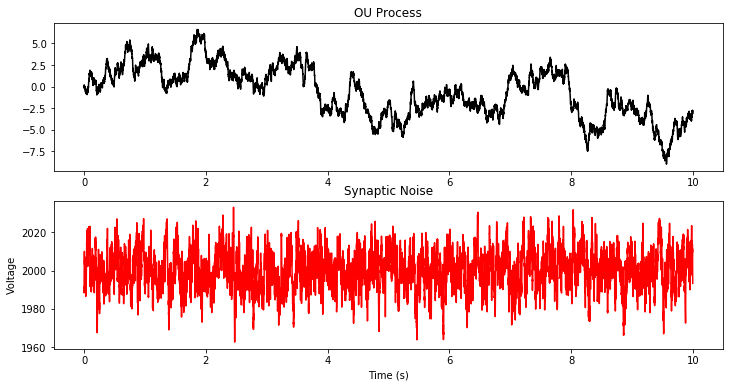

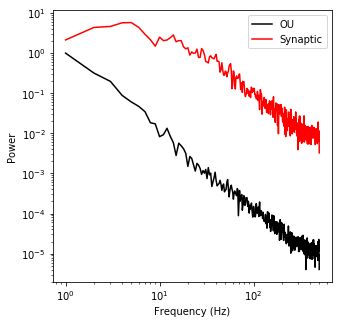

In [4]:
ou_noise = sim.sim_ou_process(n_seconds, fs)
syn_noise = sim.sim_synaptic_noise(n_seconds, fs)

# Plot time series
plt.figure(figsize=(12,6))
plt.subplot(2,1,1, title='OU Process')
plt.plot(t, ou_noise, 'k')
plt.subplot(2,1,2, title='Synaptic Noise')
plt.plot(t, syn_noise, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

# Plot power spectrum
f, ou_psd = spectral.compute_spectrum(ou_noise, fs)
f, syn_psd = spectral.compute_spectrum(syn_noise, fs)
plt.figure(figsize=(5,5))
plt.loglog(f, ou_psd, 'k', label='OU')
plt.loglog(f, syn_psd, 'r', label='Synaptic')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

# Simulate a stationary oscillator
In addition to noise, you may also want to simulate an oscillatory process. We can do that with neurodsp, with arbitrary rise-decay symmetry.

Text(0,0.5,'Power')

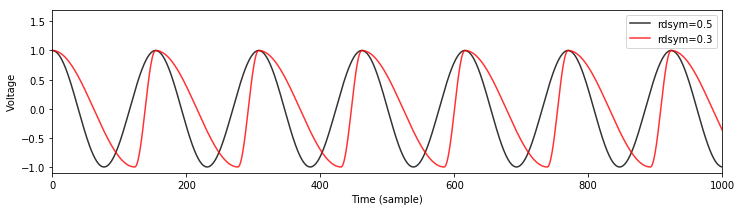

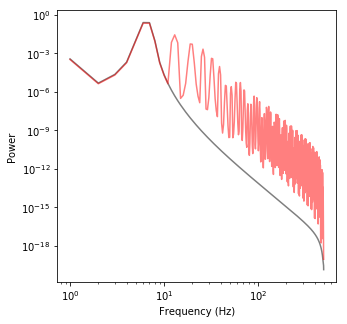

In [5]:
# Simulate symmetric oscillator
n_samples_cycle = 100
fs = 1000
osc_freq = 6.5
oscA = sim.sim_oscillator(n_samples_cycle, fs, osc_freq, rdsym=.5)
oscB = sim.sim_oscillator(n_samples_cycle, fs, osc_freq, rdsym=.2)

# Plot time series
plt.figure(figsize=(12,3))
plt.plot(oscA, 'k', label='rdsym='+str(.5), alpha=.8)
plt.plot(oscB, 'r', label='rdsym='+str(.3), alpha=.8)
plt.ylim((-1.1, 1.7))
plt.xlim((0, 1000))
plt.legend()
plt.xlabel('Time (sample)')
plt.ylabel('Voltage')

# Plot power spectrum
fA, psdA = spectral.compute_spectrum(oscA, 1000)
fB, psdB = spectral.compute_spectrum(oscB, 1000)
plt.figure(figsize=(5,5))
plt.loglog(fA, psdA, 'k', alpha=.5)
plt.loglog(fB, psdB, 'r', alpha=.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

Notice the strong harmonics resulting from the non-sinusoidal nature of the red oscillation.

# Simulate a noisy oscillator
In order to simulate a signal that looks more like a brain signal, you may want to simulate both an oscillation and noise. We also do this with neurodsp bycan combining all of the above, with control over the power ratio between oscillation and noise.

You can use any of the above noise models to generate the background noise by passing in its name (str argument) and the required model parameters as a dictionary.

Text(0,0.5,'Power')

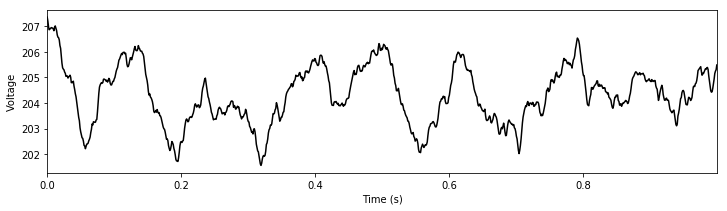

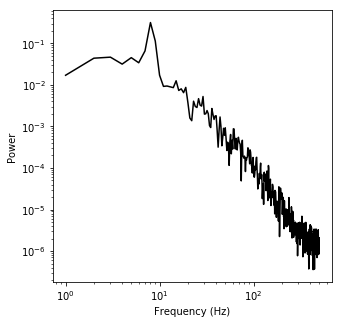

In [6]:
osc_freq = 8
n_seconds = 5
fs = 1000
rdsym = .3
SNR=1.

noise_model = 'synaptic'
noise_args = {'n_neurons':1000, 'firing_rate':2, 't_ker':1.0, 'tau_r':0.002, 'tau_d':0.02}
t = np.arange(0, n_seconds, 1/fs)
signal = sim.sim_noisy_oscillator(n_seconds, fs, osc_freq, noise_model, noise_args, ratio_osc_var=SNR)

plt.figure(figsize=(12,3))
samps_plot = np.arange(1000)
plt.plot(t[samps_plot], signal[samps_plot], 'k')
plt.xlim((0,t[samps_plot[-1]]))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

# Plot power spectrum
f, psd = spectral.compute_spectrum(signal, fs)
plt.figure(figsize=(5,5))
plt.loglog(f, psd, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

# Simulate a bursting oscillator
Sometimes we want to study oscillations that come and go, so it can be useful to simulate oscillations with this property. We can do this by controlling the probability that a burst will start or stop with each new cycle.

Text(0,0.5,'Voltage')

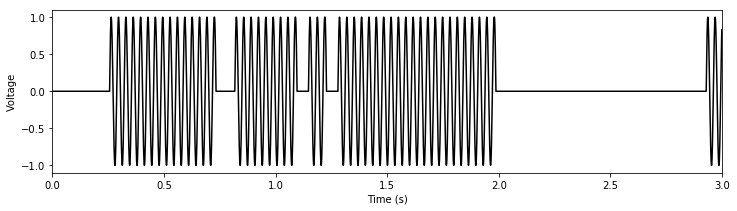

In [7]:
osc_freq = 30
n_seconds = 3
fs = 1000
prob_enter_burst = .1
prob_leave_burst = .1

osc = sim.sim_bursty_oscillator(n_seconds, fs, osc_freq, 
                                prob_enter_burst=prob_enter_burst, prob_leave_burst=prob_leave_burst)

plt.figure(figsize=(12,3))
plt.plot(np.arange(0,n_seconds,1/fs), osc, 'k')
plt.xlim((0,n_seconds))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

### We can shorten burst duration by increasing the probability to leave bursts

Text(0,0.5,'Voltage')

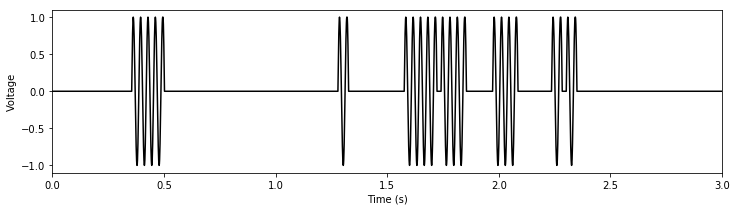

In [8]:
prob_leave_burst = .4

osc = sim.sim_bursty_oscillator(n_seconds, fs, osc_freq, 
                                prob_enter_burst=prob_enter_burst, prob_leave_burst=prob_leave_burst)

plt.figure(figsize=(12,3))
plt.plot(np.arange(0,n_seconds,1/fs), osc, 'k')
plt.xlim((0,n_seconds))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

### We can increase the number of bursts by increasing the probability to enter a burst

Text(0,0.5,'Voltage')

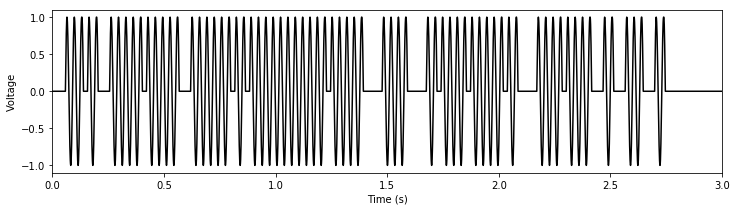

In [9]:
prob_enter_burst = .4

osc = sim.sim_bursty_oscillator(n_seconds, fs, osc_freq, 
                                prob_enter_burst=prob_enter_burst, prob_leave_burst=prob_leave_burst)

plt.figure(figsize=(12,3))
plt.plot(np.arange(0,n_seconds,1/fs), osc, 'k')
plt.xlim((0,n_seconds))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

### We can also control the variance in amplitude, period, and rise-decay symmetry across cycles and bursts
This is done in the `cycle_features` argument, which is a dictionary that can take the following keys:
    * amp_mean - mean cycle amplitude
    * amp_std - standard deviation of cycle amplitude
    * amp_burst_std - std. of mean amplitude for each burst
    * period_mean - mean period (computed from `freq`)
    * period_std - standard deviation of period (samples)
    * period_burst_std - std. of mean period for each burst
    * rdsym_mean - mean rise-decay symmetry
    * rdsym_std - standard deviation of rdsym
    * rdsym_burst_std - std. of mean rdsym for each burst

See the source code for the defaults used.

For example, we can increase the variability in amplitude by increasing `amp_std` (default = .1)

Text(0,0.5,'Voltage')

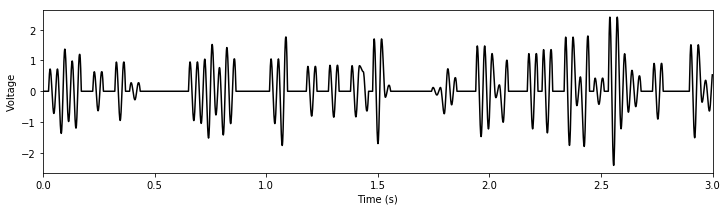

In [10]:
cycle_features = {'amp_std': .5}

osc = sim.sim_bursty_oscillator(n_seconds, fs, osc_freq, 
                                prob_enter_burst=prob_enter_burst, prob_leave_burst=prob_leave_burst, cycle_features=cycle_features)

plt.figure(figsize=(12,3))
plt.plot(np.arange(0,n_seconds,1/fs), osc, 'k')
plt.xlim((0,n_seconds))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

### As with the stationary oscillator, we can also simulate a bursting oscillator with brown noise

Text(0,0.5,'Power')

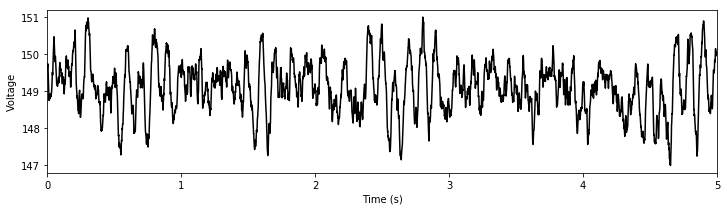

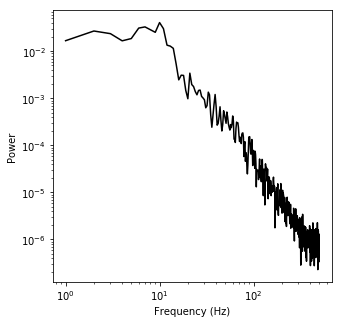

In [11]:
osc_freq = 10
n_seconds = 5
SNR=2.

noise_model = 'synaptic'
noise_args = {'n_neurons':1000, 'firing_rate':2, 't_ker':1.0, 'tau_r':0.002, 'tau_d':0.02}
t = np.arange(0, n_seconds, 1/fs)
osc = sim.sim_noisy_bursty_oscillator(n_seconds, fs, osc_freq, noise_model, noise_args, ratio_osc_var=SNR)

plt.figure(figsize=(12,3))
plt.plot(t, osc, 'k')
plt.xlim((0,n_seconds))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')

# Plot power spectrum
f, psd = spectral.compute_spectrum(osc, fs)
plt.figure(figsize=(5,5))
plt.loglog(f, psd, 'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')